# SWiFT Template
Demonstration of some of the mmctools functions and standards for postprocessing WRF-LES output <br>
Also includes examples of MMC spectra and correlation lengthscale functions.

#############################################################################

## Preamble
Set file paths, enter physical constants, import modules, etc...

### File paths and file names

In [1]:
# File paths, customize to your own directory tree
simulation_loc = '/p/lscratchh/mirocha2/SWiFT/2022/NEUTRAL/SA_DX12_DZ4_256X256_WD286_PBLH1000/'
pdata_loc = '/p/lustre3/lassman1/A2E_MMC/SWiFT/process_data/example_routine/'

fname_stem = 'wrfout_d01*'

In [2]:
# pdata save filenames
pdata_3D = 'pdata_3d.nc'
pdata_spectra = 'pdata_spectra.nc'



In [3]:
import glob
flist = glob.glob( simulation_loc + fname_stem )
flist.sort()

### Import modules

In [4]:
# Well-known python modules (i.e, available through conda)
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import glob
import os
import sys


In [5]:
# Less well-known

import wrf # as wrf

module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/mmctools/')
#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/')                                                          
if module_path not in sys.path:
    sys.path.append(module_path)
import mmctools

### Physical constants and other parameters

In [6]:
g = 9.81 #[m/s/s], gravitational constant

### User-defined functions

In [7]:
########################
# Postprocess WRF output
########################
#
#
#    The purpose of this function is to take the DataSet that is produced from an xarray 'open_mfdataset'
#         function call and to modify it to work well with mmctools functions. This includes:
#               -Renaming dimensions and coordinates to code standards
#               -Computing 1-D Z [m] variable and assigning it as a coordinate
#               -Destaggering winds
#               -Returns only the requested variables (optional)
#               -Truncates the simulation output at some height (optional)

def postprocess_wrf_outout( ds, variable_list = ['U', 'V', 'W', 'T', 'UST'], z_max = None ):
    '''
    Changes coordinate, dimension, and variable names, computes z, destaggers wind fields.
        ds: Xarray Dataset. Default from open_mfdataset on all WRF variables
        
        variable_list: Array-liike. Contains variable names (strings) to be extracted from the WRF output. Default is U, V, W, and T
            (wind components and potential temperature)
            
        z_max: maximum z (float). If defined, any model output above this height will be truncated. Default is None.
    '''
    
    # Rename dims, and drop XLAT/XLONG coords (since they're all 0 for an idealized run)
    print("Renaming dims...")
    ds = ds.rename_dims( {'west_east': 'nx', 'south_north': 'ny', 'bottom_top': 'nz',
                'west_east_stag': 'nx_stag', 'south_north_stag': 'ny_stag', 'bottom_top_stag': 'nz_stag'})

    ds = ds.drop(['XLAT','XLONG','XLAT_U','XLONG_U','XLAT_V','XLONG_V'])
    
    # Compute x, y, and z. Assign as coords.
    print("Computing x, and y...")
    ds['x'] = ds.nx * ds.DX
    ds['y'] = ds.ny * ds.DY

    print('...and now z...')

    ds['z_stag_4D'] = ( ds.PH + ds.PHB) / g
    ds['z_stag_1D'] = ds.z_stag_4D.mean(dim = ('nx', 'ny', 'Time') )
    z1D = (ds.z_stag_1D.values[:-1] + \
           ds.z_stag_1D.values[1:] ) / 2.
    ds['z1D'] = xr.DataArray( z1D, dims = 'nz' )

    print("Assigning coords...")
    ds  =  ds.assign_coords({'x': ds.x, 'y': ds.y, 'z': ds.z1D})
    
    # Truncate above z_max
    if z_max is not None:
        print(f"z_max is defined, truncating above {z_max} m")
        z_ind = np.where( ds.z1D > z_max )
        #print(z_ind)
        if len(z_ind) == 0:
            print(f"z_max = {z_max} is higher than model top")
            print("continuing")
        else:
            z_ind = z_ind[0][0]
            #print(z_ind)
            ds = ds.isel(nz = slice(0,z_ind + 1), nz_stag =slice(0,z_ind + 2) )
            print(f"Grid cells above {z_max} discarded")
    
    else:
        print("z_max is none, processing entire domain")
        
    print("destaggering winds...")
    ds = ds.rename({'U': 'U_stag', 'V': 'V_stag', 'W': 'W_stag'})
    print('...U...')
    ds['U'] = wrf.destagger( ds.U_stag, stagger_dim = 3, meta = True)
    print('...V...')
    ds['V'] = wrf.destagger( ds.V_stag, stagger_dim = 2, meta = True)
    print('...and now W...')
    ds['W'] = wrf.destagger( ds.W_stag, stagger_dim = 1, meta = True)
    
    # Grab only variables of interest
    if variable_list is not None:
        print("variables_list is defined, grabbing only these variables")
        data_variables = {}
        for v in variable_list:
            data_variables[v] = ds[v]
        ds = xr.Dataset( data_vars = data_variables, coords = ds.coords)
    else:
        print("Including all variables")
    
    return ds


    

In [8]:
########################
# calc_mean_pert
########################
# Calculate bar and prime (mean and perturbation) quantities
#

def calc_mean_pert( ds, variable_list = ['U', 'V', 'W'], mean_wind_dir = 'periodic',  ):
    '''
    Purpose of this function is to compute the mean and perturbation quantities for computing fluxes and stresses.
    
        ds: xarray Dataset. Contains the coords, dims, and variables (U,V,W) 
            that have been computed by the postprocessing function above
        variable_list: array-like. Contains variable names (strings) for mean/perturbation quantities.
            Must be 4-D variables using x/y/z coords, error-catches are not implemented.
        mean_wind_dir: either 'periodic' (default) or 'zonal' (i.e. mean wind dir is from west to east).
            periodic: compute means on x/y planes to get mean quantities as a function of time and height
            zonal: mean quantities will be computed on lines of constant x, so mean will also be a function of x.
                this means less statistical power, and some temporal averaging may be required, but that is not
                accounted for in this function (yet)
    '''
    
    mean_str_suff = '_bar'
    pert_str_suff = '_p'
    
    for vv in variable_list:
        print(vv)
        mean_str = vv + mean_str_suff
        pert_str = vv + pert_str_suff
        
        if mean_wind_dir == 'periodic':
            print("Periodic simulation")
            ds[mean_str] = ds[vv].mean(dim = ('nx', 'ny'))
            ds[pert_str] = ds[vv] - ds[mean_str]
        elif mean_wind_dir == 'zonal':
            print("Zonal simulation, may need some temporal averaging for power")
            ds[mean_str] = ds[vv].mean(dim = ('nx'))
            ds[pert_str] = ds[vv] - ds[mean_str]
    return ds
    

In [9]:
########################
# calc_stresses
########################
# Calculate stress terms
#

def calc_stresses( ds, do_uw = True, do_vw = False, do_uv = False):
    '''
    Calculate components of the Stress-Energy tensor relevant to shear production of turbulence
        ds: xarray dataset.
        do_uw: Boolean (default True). If true, calculates tau13 (the u'w' component of the stress energy tensor)
        do_vw: Boolean (default False). If true, calculates tau23 (the u'w' component of the stress energy tensor)
        do_uv: Boolean (default False). If true, calculates tau12 (the u'w' component of the stress energy tensor)
    '''
    if do_uw:
        print('calculating tau13...')
        ds['tau13'] = ( ds.U_p * ds.W_p ).mean(dim = ('nx', 'ny'))
    if do_vw:
        print('calculating tau23...')
        ds['tau23'] = ( ds.V_p * ds.W_p ).mean(dim = ('nx', 'ny'))
    if do_uv:
        print('calculating tau12...')
        ds['tau12'] = ( ds.U_p * ds.V_p ).mean(dim = ('nx', 'ny'))
        
    return ds
    

In [10]:
########################
# calc_tke
########################
# Calculate resolved TKE
#

def calc_tke( ds ):
    '''
    Calculates RESOLVE LES TKE. Does not compute the subgrid component.
        ds: xarray dataset.
    '''
    print("calculating TKE...")
    ds['TKE'] = 1./2. * (  ( ds.U_p**2. ).mean(dim = ('nx', 'ny') ) \
                         + ( ds.V_p**2. ).mean(dim = ('nx', 'ny') ) \
                         + ( ds.W_p**2. ).mean(dim = ('nx', 'ny') ) )
    
    return ds

## Actual analysis begins

### Load 4-D model output

In [70]:
# Use xarray.open_mfdataset. https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html

save_pdata = True

if os.path.exists(pdata_loc + pdata_3D):
    print("Process data exists")
    ds = xr.open_dataset( pdata_loc + pdata_3D )
else:
    print("Process data does not exist, reading from WRFOUT")
    ds = xr.open_mfdataset( flist, \
                           chunks = {'Time':10},
                           combine = 'nested',
                           concat_dim = 'Time'  )
    ds = postprocess_wrf_outout( ds, z_max = 1100 ) #No subgrid stress/TKE components
    ds = calc_mean_pert( ds )
    ds = calc_stresses( ds )
    ds = calc_tke( ds )
    if save_pdata:
        print("Saving pdata...")
        ds.to_netcdf(pdata_loc + pdata_3D)
    

#sys.exit()

Process data exists


# Compute Spectra

In [69]:
save_spectra_pdata = True


if os.path.exists(pdata_loc + pdata_3D):
    print("Spectra process data exists")
    psd_ds = xr.open_dataset( pdata_loc + pdata_spectra )
else:
    from mmctools.helper_functions import calc_spectra
    
    print("Spectra process data missing, calculating")
    ds2 = ds.assign_coords( {'nx' : ds.nx, 'ny' : ds.ny, 'nz' : ds.nz, 'Time' : ds.Time})
    psd_list = []
    NT = len(ds.Time)
    for tt in range(0,NT):
        print(f"Time {tt} of {NT}")
        psd_hr1_temp = calc_spectra( ds2.isel(Time = tt),\
                            var_oi=['U_p','W_p'],\
                            spectra_dim='ny',\
                            #average_dim='XTIME',\
                            average_dim='nx',\
                            level_dim='nz',
                            level = [5, 10, 20, 40] \
                             )

        psd_list.append(psd_hr1_temp.mean(dim = 'nx'))
    
    psd_ds = xr.concat( psd_list, "Time" )
    psd_ds = psd_ds.assign_coords({"Time": ds.Time, "XTIME": ds.XTIME})
    
    psd_ds['z'] = xr.DataArray( ds.z[[5, 10, 20, 40]].values, dims = 'nz' )
    
    if save_spectra_pdata:
        print("Saving spectra process data")
        psd_ds.to_netcdf( pdata_loc + pdata_spectra )
    

Spectra process data exists


# Resample to hourly means
Requires playing with some dimension names surrounding Time

In [14]:
ds = ds.swap_dims({'Time': 'XTIME'})



In [15]:
ds_1hr = ds.resample({'XTIME':'1H'}).mean()

/g/g12/lassman1/anaconda3/envs/mmc/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [38]:
psd_ds = psd_ds.swap_dims({'Time': 'XTIME'})

In [39]:
psd_ds_1hr = psd_ds.resample({'XTIME':'1H'}).mean()

/g/g12/lassman1/anaconda3/envs/mmc/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [25]:
NT_hr = len( ds_1hr.XTIME )

# Some plots

In [26]:
time_colormap = plt.cm.plasma(np.linspace(0, 1, NT_hr) )

### Vertical profiles

Text(0, 0.5, 'Height [m]')

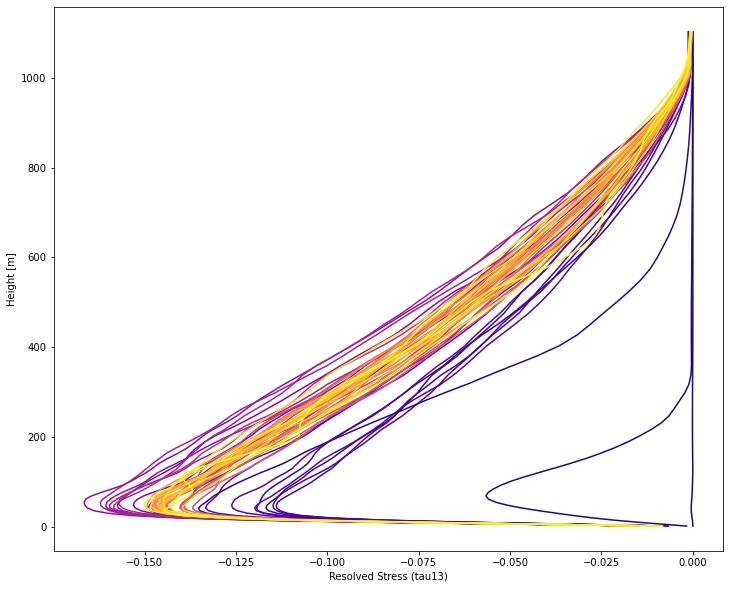

In [28]:
# Tau13 vertical profile, color a function of time
f, ax = plt.subplots( figsize = (12, 10) )


for tt in range(0, NT_hr):
    ax.plot( ds_1hr.isel(XTIME = tt).tau13, ds_1hr.z , c = time_colormap[tt] )
    
ax.set_xlabel('Resolved Stress (tau13)')
ax.set_ylabel('Height [m]')



(0.0, 200.0)

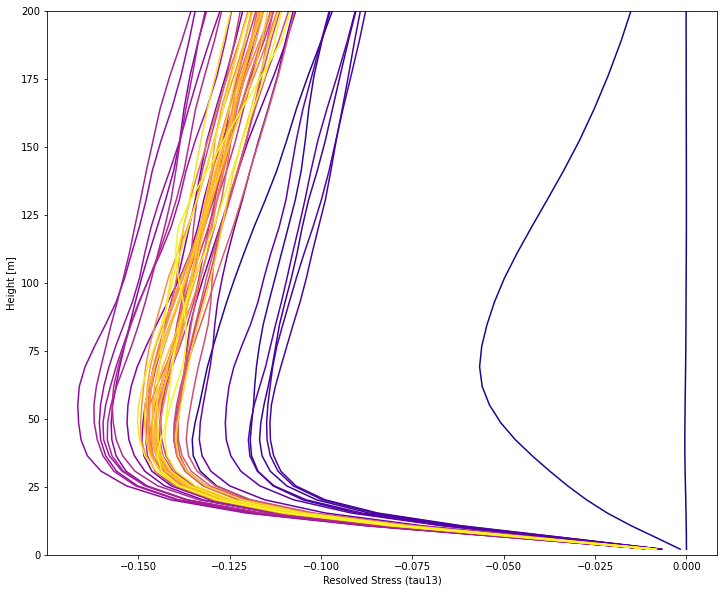

In [30]:
# Tau13 vertical profile, color a function of time
f, ax = plt.subplots( figsize = (12, 10) )


for tt in range(0, NT_hr):
    ax.plot( ds_1hr.isel(XTIME = tt).tau13, ds_1hr.z , c = time_colormap[tt] )
    
ax.set_xlabel('Resolved Stress (tau13)')
ax.set_ylabel('Height [m]')

ax.set_ylim([0.,200])

Text(0, 0.5, 'Height [m]')

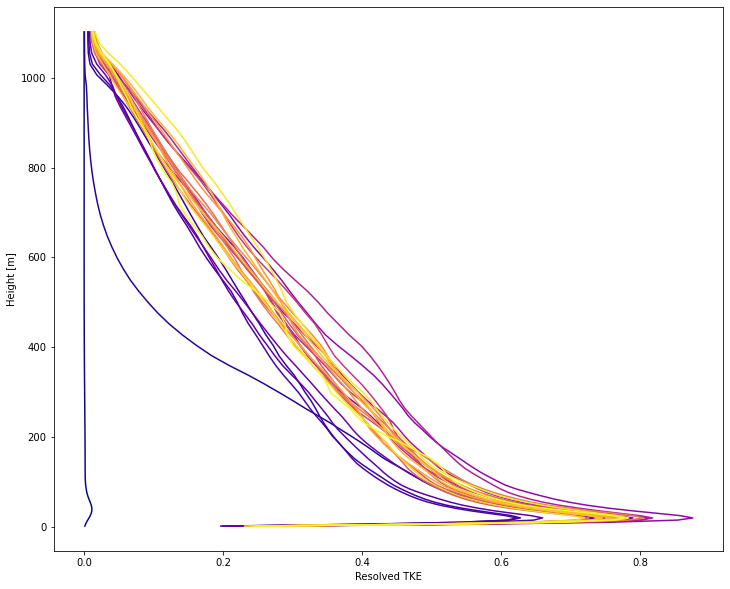

In [29]:
# TKE vertical profile, color a function of time
f, ax = plt.subplots( figsize = (12, 10) )


for tt in range(0, NT2)[::2]:
    ax.plot( ds_1hr.isel(XTIME = tt).TKE, ds_1hr.z , c = time_colormap[tt] )
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')



(0.0, 200.0)

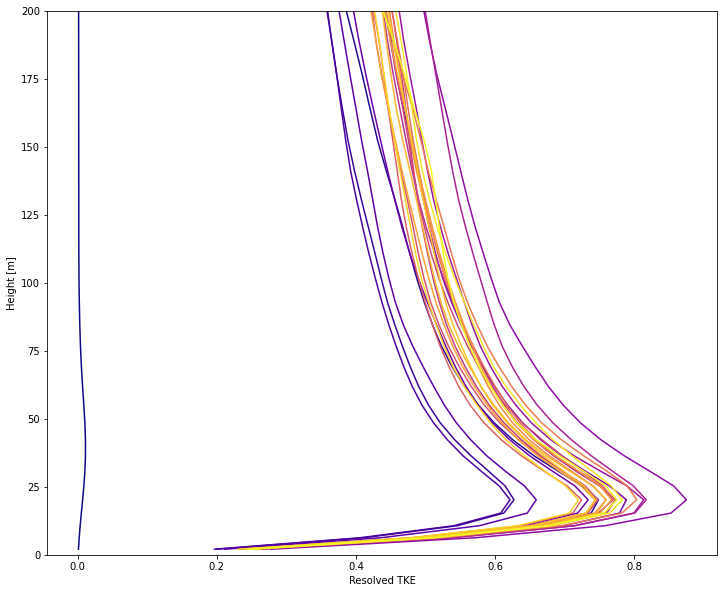

In [31]:
# TKE vertical profile, color a function of time
f, ax = plt.subplots( figsize = (12, 10) )


for tt in range(0, NT2)[::2]:
    ax.plot( ds_1hr.isel(XTIME = tt).TKE, ds_1hr.z , c = time_colormap[tt] )
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')

ax.set_ylim([0., 200])

### Spectra

In [66]:
z_spectra = psd_ds_1hr.z.isel(XTIME = 0)
psd_ds_1hr['U_p_norm_power'] = psd_ds_1hr.U_p * psd_ds_1hr.frequency
psd_ds_1hr['W_p_norm_power'] = psd_ds_1hr.W_p * psd_ds_1hr.frequency

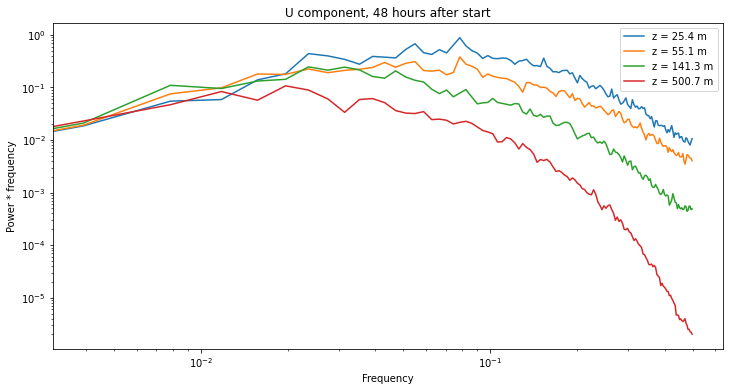

In [67]:
f, ax  = plt.subplots(figsize = ( 12, 6) )
tind = 48

for k in range(0,len(z_spectra)):
    ax.plot( psd_ds_1hr.frequency, psd_ds_1hr.U_p_norm_power.isel(XTIME = tind, nz = k),\
            label = f"z = {z_spectra.isel(nz=k).values:.1f} m" )

ax.set_ylabel('Power * frequency')    
ax.set_xlabel('Frequency')

ax.set_title(f"U component, {tind} hours after start")

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc = 'best')


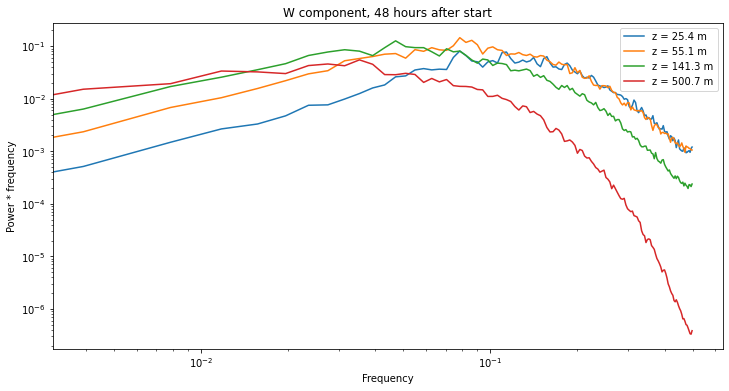

In [68]:
f, ax  = plt.subplots(figsize = ( 12, 6) )
tind = 48

for k in range(0,len(z_spectra)):
    ax.plot( psd_ds_1hr.frequency, psd_ds_1hr.W_p_norm_power.isel(XTIME = tind, nz = k),\
            label = f"z = {z_spectra.isel(nz=k).values:.1f} m" )

ax.set_ylabel('Power * frequency')    
ax.set_xlabel('Frequency')

ax.set_title(f"W component, {tind} hours after start")

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc = 'best')
